In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt


param_inds = [3, 5]
Cdir = '/global/cfs/cdirs/m3623/datasets/RLtest/'
with h5py.File(Cdir+'data.h5', 'r') as f:
    sympt = f['symptomatic3D'][...].astype(np.int32)
    bios = f['parBio'][:,param_inds]
    unis = f['uniBio'][:,param_inds]
    
print(sympt.shape)
print(bios.shape)
print(unis.shape)

datFile = '/global/homes/p/pharring/covid/epiCorvid/corvid_march/corviddata/seattle-tracts.dat'
dat = np.genfromtxt(datFile, delimiter=',')[:,3]
print(dat.shape)
#sympt = sympt[8500:]
#bios = bios[8500:]

(10048, 124, 5, 365)
(10048, 2)
(10048, 2)
(124,)


In [9]:
agg = np.sum(sympt, axis=(1,2))
cumsympt = np.cumsum(agg, axis=-1)
states = np.stack([agg, cumsympt], axis=-1)
print(states.shape)

(10048, 365, 2)


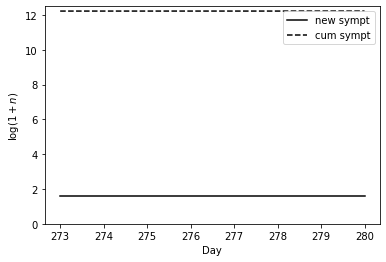

In [19]:
needsplot = True
f = plt.figure()
cnt=0
for sim in range(1):
    cnt+=1
    sim = np.random.randint(sympt.shape[0])
    day = np.random.randint(3,50)*7
    #print(sim, day)
    samp_t1 = states[sim,day,:]
    samp_t2 = states[sim,day+7,:]
    samp_pars = bios[sim]
    if samp_t1[0]==0 or samp_t2[0]==0:
        continue

    idxs = np.where(np.any(bios - samp_pars, axis=1), False, True)
    matches = states[idxs]
    if matches.shape[0]==0:
        continue

    close05 = []
    close10 = []
    L1 = []

     
    for i in range(matches.shape[0]):
        sim2 = matches[i]
        err = np.abs((samp_t1 - sim2)/samp_t1)
        day2 = np.argmin(np.mean(err[:357,:], axis=1))
        if samp_t1[0] == sim2[day2,0]:
            continue
        mean = err[day2].mean()
        if mean<0.05:
            close05.append(sim2[day2])
            new = sim2[day2+7]
            if needsplot:
                plt.plot([day,day+7], np.log1p([sim2[day2,0], new[0]]), color='r', alpha=0.1)
                plt.plot([day,day+7], np.log1p([sim2[day2,1], new[1]]), color='b', alpha=0.1)
            diff = np.abs((samp_t2 - new)/samp_t2)
            L1.append(diff)
            
    if needsplot:
        plt.plot([day,day+7], np.log1p([samp_t1[0], samp_t2[0]]), 'k-', label='new sympt')
        plt.plot([day,day+7], np.log1p([samp_t1[1], samp_t2[1]]), 'k--', label='cum sympt')
        plt.ylabel('$\log (1+n)$')
        plt.xlabel('Day')
        plt.ylim((0,12.5))
        plt.legend()
        plt.show()
        needsplot=False
    if not L1:
        continue
    L1 = np.stack(L1, axis=0)
    